1 random over sampler

2 Smote

3 Under Sampler

4 tomek links

5 weights "balance

6 stratify

5 ile alakasız üsttekiler ama bak nedir diye

hem stratify ile hem onsuz dene bak sonuçlara

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string
import nltk
from nltk.corpus import stopwords

In [ ]:
data = pd.read_csv("spam.csv",encoding="ISO-8859-1") 

In [ ]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
data.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [5]:
data.drop(columns=["Unnamed: 2","Unnamed: 3","Unnamed: 4"],inplace = True)
data.columns = ["target","text"]
data["target"] =data["target"].replace(["ham"],0)
data["target"] =data["target"].replace(["spam"],1)

In [6]:
data["target"].value_counts()

0    4825
1     747
Name: target, dtype: int64

In [7]:
data = data.drop_duplicates(keep="first")

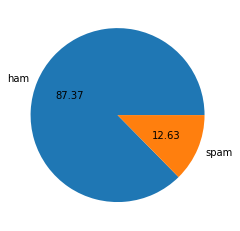

In [9]:
plt.pie(data["target"].value_counts(),labels=["ham","spam"],autopct = "%0.2f");

In [10]:
!pip install nltk
nltk.download("punkt")
nltk.download("stopwords")
     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = [] 
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words("english") and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
        
    return " ".join(y)

In [12]:
data["transformed_text"]=data["text"].apply(transform_text)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(data["transformed_text"]).toarray()
Y = data["target"].values

In [16]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

ros = RandomOverSampler(random_state=42)
smote = SMOTE(random_state=42)
Xros, Yros = ros.fit_resample(X, Y)
Xsmote , Ysmote = smote.fit_resample(X, Y)

rus = RandomUnderSampler(random_state=42)
tomek = TomekLinks(sampling_strategy="auto")
Xrus , Yrus = rus.fit_resample(X, Y)
Xtomek , Ytomek = tomek.fit_resample(X, Y)

In [17]:
target = [Y, Yros, Ysmote, Yrus, Ytomek]
train = [X, Xros, Xsmote, Xrus, Xtomek]
     
samplers= {
    "RandomOverSampler_Length": [len(Yros)],
    "SMOTE_Length": [len(Ysmote)], 
    "RandomUnderSampler_Length": [len(Yrus)],   
    "TomekLinks_Length": [len(Ytomek)],
    "Actual_Length": [len(Y)]
}
     

samplers_df = pd.DataFrame.from_dict(data=samplers, orient="index")
samplers_df

,0
RandomOverSampler_Length,9032
SMOTE_Length,9032
RandomUnderSampler_Length,1306
TomekLinks_Length,5167
Actual_Length,5169


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [20]:
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
adb = AdaBoostClassifier()
lr = LogisticRegression()
svc = SVC()

clfs = {
    "DT":dt,
    "KNN":knn,
    "RF":rf,
    "AB":adb,
    "LR":lr,
    "SVC":svc
}

In [25]:
sampler_list = [
    "RandomOverSampler_Length",
    "SMOTE_Length",
    "RandomUnderSampler_Length",
    "TomekLinks_Length",
    "Actual_Length"
]

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

without_stratify=list()
for i, j in zip(train,target):
  Xtrain, Xtest, Ytrain, Ytest = train_test_split(i,j,test_size=0.2,random_state=42)
  sampler2 = dict()
  for key,values in clfs.items():
    values.fit(Xtrain,Ytrain)
    Ypred = values.predict(Xtest)
    sampler2[key] = accuracy_score(Ytest,Ypred)
  without_stratify.append(sampler2)

In [26]:
without_df = pd.DataFrame(data=without_stratify,columns=clfs.keys())
without_df["Inbalance_methods"] = sampler_list
without_df.set_index("Inbalance_methods",inplace=True)
without_df

,DT,KNN,RF,AB,LR,SVC
Inbalance_methods,,,,,,
RandomOverSampler_Length,0.949710,0.910058,0.974855,0.950677,0.958414,0.974855
SMOTE_Length,0.976757,0.941893,0.995019,0.933592,0.975650,0.997786
RandomUnderSampler_Length,0.970670,0.665744,0.991699,0.957388,0.953514,0.995019
TomekLinks_Length,0.885496,0.671756,0.942748,0.916031,0.938931,0.950382
Actual_Length,0.951644,0.907157,0.967118,0.958414,0.960348,0.972921


In [27]:
with_stratify=list()
for i, j in zip(train,target):
  Xtrain,Xtest,Ytrain,Ytest = train_test_split(i,j,test_size=0.2,random_state=42,stratify=j)
  sampler3 = dict()
  for key,values in clfs.items():
    values.fit(Xtrain,Ytrain)
    Ypred = values.predict(Xtest)
    sampler3[key] = accuracy_score(Ytest,Ypred)
  with_stratify.append(sampler3)

In [28]:
with_df = pd.DataFrame(data=with_stratify,columns=clfs.keys())
with_df["Inbalance_methods"] = sampler_list
with_df.set_index("Inbalance_methods",inplace=True)
with_df

,DT,KNN,RF,AB,LR,SVC
Inbalance_methods,,,,,,
RandomOverSampler_Length,0.954545,0.909091,0.975822,0.963250,0.958414,0.971954
SMOTE_Length,0.974543,0.951854,0.993359,0.946320,0.977310,0.997786
RandomUnderSampler_Length,0.965689,0.650802,0.994466,0.965136,0.959048,0.996126
TomekLinks_Length,0.931298,0.683206,0.965649,0.919847,0.958015,0.961832
Actual_Length,0.947776,0.909091,0.976789,0.968085,0.958414,0.975822
